<a href="https://colab.research.google.com/github/Erifai/Bi_Project/blob/main/Projet_BI_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 6.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:

#!pip install spacy
!pip install -U spacy 
!pip install spacy-transformers
!pip install spacy_entity_linker
!python3 -m spacy_entity_linker "download_knowledge_base"

#à executer une seule fois et de redémarrer le runtime avec GPU 

     |████████████████████████████████| 5.9 MB 5.5 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 456 kB 50.8 MB/s 
     |████████████████████████████████| 627 kB 45.3 MB/s 
     |████████████████████████████████| 10.1 MB 32.7 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 998 kB 9

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re
import operator
from functools import reduce


In [3]:
#df = pd.read_fwf('/content/DBLP_Subset.txt')
#df=pd.read_table('/content/DBLP_Subset.txt',header=None)
#df = pd.read_csv("/content/DBLP_Subset.txt",sep="\n")
reading_file = open("/content/DBLP_Subset.txt", "r")

new_file_content = ""
count = 0
for line in reading_file:

  stripped_line = line.strip()

  new_line = stripped_line.replace(';',',')
  if "#!" in new_line :
    count=0
  new_line = new_line.replace('#c',';').replace('#*','\n;').replace('#c',';').replace('#t',';').replace('#index',';').replace('#!',';').replace('#@',';')
  if "#%" in new_line and count==0 :
    #print(new_line)
    new_line = new_line.replace('#%',';')
    #print(new_line)

    count =1


  new_file_content += new_line


reading_file.close()
writing_file = open("sample.txt", "w")
writing_file.write(new_file_content)
writing_file.close()
df = pd.DataFrame([x.split(';') for x in new_file_content.split('\n')])
# .replace('#c',';').replace('#*',';').replace('#c%',';').replace('#t',';').replace('#index',';').replace('#!',';')
#   df = pd.DataFrame([x.split(';') for x in lines.split('\n')])

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
df

,0,1,2,3,4,5,6,7
0,,None,None,None,None,None,None,None
1,,Improved Channel Routing by Via Minimization a...,Chung-Kuan ChengDavid N. Deutsch,1988,DAC,131751,133716#%133521#%134343,Channel routing area improvement by means of v...
2,,A fast simultaneous input vector generation an...,Lei ChengLiang DengDeming ChenMartin D. F. Wong,2006,DAC,131752,132550#%530568#%436486#%134259#%283007#%134422...,Input vector control (IVC) technique is based ...
3,,On the Over-Specification Problem in Sequentia...,Kwang-Ting ChengHi-Keung Tony Ma,1992,DAC,131756,455537#%1078626#%131745,The authors show that some ATPG (automatic tes...
4,,Device and architecture co-optimization for FP...,Lerong ChengPhoebe WongFei LiYan LinLei He,2005,DAC,131759,214244#%215701#%214503#%282575#%214411#%214505...,Device optimization considering supply voltage...
...,...,...,...,...,...,...,...,...
37959,,Selection of strategies in judgment-based effo...,Magne Jørgensen,2010,Journal of Systems and Software,1600529,996865#%601059#%361510#%492786#%997634#%112851...,We currently know little about the factors tha...
37960,,Performance analysis of opportunistic broadcas...,Abbas NayebiHamid Sarbazi-AzadGunnar Karlsson,2010,Journal of Systems and Software,1600531,505564#%1114157#%412964#%588689#%53668#%692884...,This paper investigates a class of mobile wire...
37961,,Quality adaptive end-to-end packet scheduling ...,Rossella FortunaLuigi Alfredo GriecoGennaro Bo...,2010,Journal of Systems and Software,1600532,396959#%794228#%588835#%997951,In Internet multimedia streamingthe quality of...
37962,,Design and evaluation of a novel MAC layer han...,Richard Werner Nelem PazziZhenxia ZhangAzzedin...,2010,Journal of Systems and Software,1600537,666821#%784037#%506991#%505779#%1247751,In recent yearsthe IEEE 802.11 wireless networ...


In [6]:
df = df.rename(columns={0:"supprimer",1:"Titre",2:"Auteurs",3:"Année",4:"Publication",5:"IndexId",6:"IdRefrences",7:"Abstract"})

In [7]:
df.drop(columns=['supprimer'])


,Titre,Auteurs,Année,Publication,IndexId,IdRefrences,Abstract
0,None,None,None,None,None,None,None
1,Improved Channel Routing by Via Minimization a...,Chung-Kuan ChengDavid N. Deutsch,1988,DAC,131751,133716#%133521#%134343,Channel routing area improvement by means of v...
2,A fast simultaneous input vector generation an...,Lei ChengLiang DengDeming ChenMartin D. F. Wong,2006,DAC,131752,132550#%530568#%436486#%134259#%283007#%134422...,Input vector control (IVC) technique is based ...
3,On the Over-Specification Problem in Sequentia...,Kwang-Ting ChengHi-Keung Tony Ma,1992,DAC,131756,455537#%1078626#%131745,The authors show that some ATPG (automatic tes...
4,Device and architecture co-optimization for FP...,Lerong ChengPhoebe WongFei LiYan LinLei He,2005,DAC,131759,214244#%215701#%214503#%282575#%214411#%214505...,Device optimization considering supply voltage...
...,...,...,...,...,...,...,...
37959,Selection of strategies in judgment-based effo...,Magne Jørgensen,2010,Journal of Systems and Software,1600529,996865#%601059#%361510#%492786#%997634#%112851...,We currently know little about the factors tha...
37960,Performance analysis of opportunistic broadcas...,Abbas NayebiHamid Sarbazi-AzadGunnar Karlsson,2010,Journal of Systems and Software,1600531,505564#%1114157#%412964#%588689#%53668#%692884...,This paper investigates a class of mobile wire...
37961,Quality adaptive end-to-end packet scheduling ...,Rossella FortunaLuigi Alfredo GriecoGennaro Bo...,2010,Journal of Systems and Software,1600532,396959#%794228#%588835#%997951,In Internet multimedia streamingthe quality of...
37962,Design and evaluation of a novel MAC layer han...,Richard Werner Nelem PazziZhenxia ZhangAzzedin...,2010,Journal of Systems and Software,1600537,666821#%784037#%506991#%505779#%1247751,In recent yearsthe IEEE 802.11 wireless networ...


In [8]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17852 entries, 1 to 37963
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   supprimer    17852 non-null  object
 1   Titre        17852 non-null  object
 2   Auteurs      17852 non-null  object
 3   Année        17852 non-null  object
 4   Publication  17852 non-null  object
 5   IndexId      17852 non-null  object
 6   IdRefrences  17852 non-null  object
 7   Abstract     17852 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


In [9]:

#punctuations
punctuations = string.punctuation
#stopwords
stop_words = list(STOP_WORDS)
def clean_text(
  string : str,
  ponctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
  stop_words = stop_words)->str : 

  #URLs
  string = re.sub(r"https?://\S+|www\.\S+",'',string)
  #html 
  string = re.sub(r'<.*?>','',string)
  #Numbers
  string = re.sub(r'[0-9]+','',string) 

  #Remove punctuations
  for x in string.lower():
    if x in punctuations:
      string = string.replace(x,"")
  #To lower
  string = string.lower()
  #Remove stop words
  string = ' '.join([word for word in string.split() if word not in stop_words])
  #Cleaning the whitespaces
  string = re.sub(r'\s', ' ', string).strip()
  return string
  
clean_text("hello it's me , i was wonderning   https://jahdjadad.com     if after all this years 02 ")

'hello wonderning years'

<function matplotlib.pyplot.show>

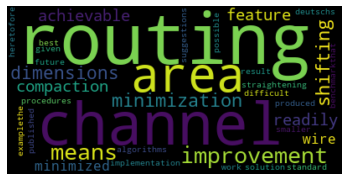

In [10]:

abstract = df.Abstract.to_list()
abstracts_cleaned = [clean_text(x) for x in abstract]
#wordcloud for one document
text = abstracts_cleaned[0]
#Creat and generate a wordcloud image :
wordcloud = WordCloud().generate(text)
#Display the generated image
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
abstracts_cleaned = [clean_text(x) for x in abstract]


In [ ]:
vectorizer = CountVectorizer()
DocTerm_abstract = vectorizer.fit_transform(abstracts_cleaned)
print('type of DocTerm_abstract : ', type(DocTerm_abstract))
print("Documents / Mots  : ",DocTerm_abstract.shape)
print(DocTerm_abstract)

DocTerm_abstract = DocTerm_abstract.toarray()
print("******************************************")
print('DocTerm_abstract', type(DocTerm_abstract))


type of DocTerm_abstract :  <class 'scipy.sparse.csr.csr_matrix'>
Documents / Mots  :  (17852, 90825)
  (0, 10652)	2
  (0, 69219)	3
  (0, 4459)	2
  (0, 37216)	1
  (0, 46918)	1
  (0, 48487)	1
  (0, 72743)	1
  (0, 20836)	1
  (0, 13075)	1
  (0, 65545)	1
  (0, 534)	1
  (0, 27916)	1
  (0, 48508)	1
  (0, 89162)	1
  (0, 77021)	1
  (0, 36965)	1
  (0, 2080)	1
  (0, 62305)	1
  (0, 62633)	1
  (0, 74731)	1
  (0, 20116)	1
  (0, 20676)	1
  (0, 26263)	1
  (0, 76329)	1
  (0, 7046)	1
  :	:
  (17851, 50463)	8
  (17851, 60411)	1
  (17851, 70734)	1
  (17851, 1732)	2
  (17851, 66577)	1
  (17851, 47431)	1
  (17851, 14544)	1
  (17851, 79064)	1
  (17851, 34249)	1
  (17851, 6446)	1
  (17851, 49002)	1
  (17851, 19085)	1
  (17851, 5543)	1
  (17851, 37869)	1
  (17851, 16793)	1
  (17851, 34616)	1
  (17851, 57559)	1
  (17851, 89316)	3
  (17851, 89317)	2
  (17851, 5940)	1
  (17851, 55333)	1
  (17851, 32511)	1
  (17851, 14569)	1
  (17851, 18959)	1
  (17851, 82113)	1


In [1]:
#Get Words List
print(vectorizer.get_feature_names())


NameError: ignored

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import spacy
import en_core_web_sm
from functools import reduce
nlp = spacy.load('en_core_web_sm')
# add pipeline (declared through entry_points in setup.py)
nlp.add_pipe("entityLinker",last=True)

In [ ]:
listEntity =[]
for a,abs in enumerate(abstracts_cleaned):
  doc = nlp(str(abs))
  listInter=[]
  #return all the entities in the whole document
  all_linked_entities = doc._.linkedEntities
  #itereate over sentences and print linked entities
  for sent in doc.sents:
    #print(sent._.linkedEntities)
    for i in range(len(sent._.linkedEntities)):
      entity = sent._.linkedEntities[i].get_id()
      listInter.append(entity)
  listEntity.append(listInter)


In [ ]:
listEntityAll = reduce(operator.concat,listEntity)
print("listEntityAll" , len(listEntityAll))
listEntityAllunique = np.unique(np.asarray(listEntityAll))
print("listEntityAllunique" , len(listEntityAllunique))


listEntityAll 132276
listEntityAllunique 6643


In [ ]:
listEntityAll = reduce(operator.concat,listEntity)
print("listEntityAll" , len(listEntityAll))
listEntityAllunique = np.unique(np.asarray(listEntityAll))
print("listEntityAllunique" , len(listEntityAllunique))

#faire la matrice 

listEntityAll 132276
listEntityAllunique 6643


In [ ]:


listEntityOne = listEntity[1]
abstracts_cleanedOne = abstracts_cleaned[1]

print(len(abstracts_cleanedOne))
print(abstracts_cleanedOne)
print(len(listEntityOne))
print(listEntityOne)

doc = nlp(str(abstracts_cleanedOne))
print("doc")
print(doc)

all_linked_entities = doc._.linkedEntities
print(len(all_linked_entities))
print(all_linked_entities)

for sent in doc.sents:
  print("----------------")
  print(sent._.linkedEntities)
  print("----------------")

799
isolated spontaneously beating atria streptozocin diabetic rats compared controls diabetic atria found reduced rates increased forces contraction reduced sensitivity inotropic effects noradrenaline isoprenaline tyramine calcium positive chronotropic responses tyramine reduced noradrenaline isoprenaline increased suggesting tyramine releasable stores noradrenaline reduced elevation glucose concentration medium mm resulted decrease inotropic sensitivity agents control diabetic rat atria resting contractile force control rat atria reduced inclusion mm deoxyglucose iu insulin ml mm acetate medium rate reduced medium containing deoxyglucose increased insulin deoxyglucose reduced inotropic increased chronotropic sensitivity isoprenaline possible mechanisms responsible changes observed discussed
25
[26018, 257331, 11853290, 11175, 1144560, 11402, 2995644, 1295020, 706, 415550, 216107, 165930, 340169, 392648, 26018, 728944, 39798, 912, 39798, 1144560, 174789, 54869047, 517596, 415550, 1295

In [ ]:
# à faire 
# construction de la matrice !
mat = np.zeros((len(listEntity),len(listEntityAllunique)),dtype=int)
mat.shape

(4354, 6643)

In [ ]:
for i in range(0,len(listEntity)-1):
  for j in range(0,len(listEntityAllunique)):
    if (listEntityAllunique[j] in listEntity[i]):
      mat[i][j] = 1


In [ ]:
listEntity[0]

[2792936,
 26018,
 227564,
 1072,
 912751,
 1072,
 12136,
 629,
 14897892,
 1984607,
 1072,
 26018,
 2294,
 7873,
 39798,
 1072,
 739302,
 1072,
 208465,
 1072,
 41719,
 739302,
 214339,
 7590,
 629,
 1072]

In [ ]:
np.where(listEntityAllunique == 2792936)

(array([4735]),)

In [ ]:
listEntityAllunique[4735]

2792936

In [ ]:
mat[0][4735]

1

In [ ]:
dictindex = dict(zip(listEntityAllunique,np.arange(len(listEntityAllunique))))
entityEmbedding = np.zeros((len(abstract),len(listEntityAllunique)))
for a in range(len(abstract)):
  lista = listEntity[a]
  indexEn = values = np.asanyarray(list(map(dictindex.get,lista)))
  print(indexEn)
  entityEmbedding[a,indexEn]=1

Streaming output truncated to the last 5000 lines.
[ 918 1146 1087 1745 4044 1088 1731 3411 1152 1088 1581 3513 2258  909
 6361 2304 2304 1456 5888 1152 1088 1456 1745 1456 1581  173 3342 4800
 2304 4088 3342 1970 3411 1456 3513]
[3190 5869 5618 3513 6529  878  124  524 4433 4433 1899 5266 1552  622
  850 2880 1605  878 2880 2781  395 1520 1605 2880  878 1925 1970 2781
 1520 1087 1758 5772 1279 3779 3513]
[1990 1745  863 6350  886 3271 1607 1827  982 2777  418  764 5041 1962
 1152 6465 1745 1745 4599 3764 1745 1990 1990  420 2198 1152]
[ 391 1910  563 1161 4683 5929  584 5280  909 1745  584]
[4039 3334  384  427  886 1076 2356  886  408 3293  221 1088 6465  511
  190 6465  677    0  384  815  384 3513 1745 6154  336  190 2020  295
  886  886 1910 1076  190 1118  336 1910 1461  295 1073  886  384 6154
  427  886 1745  190  886 1594  384 3334]
[3513 2320 1745  942 1745 5006 2828 1076  741 2947 5006  584 4355 5929
 2080 1570  408 1863 2947 3980  994 4909 1682  924 4795 5772 1962 4088
 351

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
sentence_embedding = model.encode(abstract)

In [ ]:
sentence_embedding

array([[-0.11809309,  0.6750752 , -0.69768417, ..., -0.45018017,
         0.09253447,  0.77059746],
       [-0.9927872 ,  0.7023208 , -0.7021835 , ...,  0.22458823,
         0.5512585 ,  0.37790298],
       [-0.72698784,  0.74177176, -1.0302278 , ..., -0.28845036,
         0.58756685,  0.3509244 ],
       ...,
       [-0.5932883 ,  0.4664442 , -0.75815153, ..., -0.32036734,
         0.63670015,  0.6818651 ],
       [-0.28235322,  0.41596544,  0.41327864, ...,  0.05819207,
        -0.21302798,  0.57634664],
       [-0.08899477,  0.6237656 , -0.6131523 , ..., -0.34826642,
        -0.5416375 ,  1.3500109 ]], dtype=float32)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

K=3
labels_all = np.asarray(df['label']).astype(int)

kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(DocTerm_abstract)
y_pred1 = kmeans.labels_

print('Bow representation clustering  accuracy : ',accuracy_score(labels_all,y_pred1))

Bow representation clustering  accuracy :  0.538355535140101


In [ ]:
kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(entityEmbedding)
#kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(mat)

y_pred2 = kmeans.labels_
print('Entity  representation clustering  accuracy : ',accuracy_score(labels_all,y_pred2))

Entity  representation clustering  accuracy :  0.22094625631603124


In [ ]:
kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(sentence_embedding)
y_pred3 = kmeans.labels_
print('Sentence  representation clustering  accuracy : ',accuracy_score(labels_all,y_pred3))

Sentence  representation clustering  accuracy :  0.24460266421681212


In [ ]:
!sudo apt-get install metis
!pip install Cluster_Ensembles


In [ ]:
import numpy as np
import Cluster_Ensembles as CE
clustering_1 = [0,1,1,2,0,2,1,0,2,1]
clustering_1 = y_pred1
clustering_2 = [0,1,2,0,0,2,2,1,2,1]
clustering_2 = y_pred2
clustering_3 = [2,0,0,2,1,1,1,0,1,2]
clustering_3 = y_pred3
cluster_runs = np.array([clustering_1,clustering_2,clustering_3])
print("cluster_runs" , cluster_runs)
consensus_clustering_labels = CE.cluster_ensembles(cluster_runs,verbose = True,N_clusters_max = 3)
print("consensus_clustering_labels",consensus_clustering_labels)

cluster_runs [[1 1 2 ... 2 2 2]
 [0 0 0 ... 2 1 0]
 [0 0 0 ... 2 2 1]]
*****
INFO: Cluster_Ensembles: CSPA: consensus clustering using CSPA.

#
INFO: Cluster_Ensembles: wgraph: writing wgraph_CSPA.
#

#
INFO: Cluster_Ensembles: sgraph: calling gpmetis for graph partitioning.
INFO: Cluster_Ensembles: sgraph: (hyper)-graph partitioning completed; loading wgraph_CSPA.part.3
#

INFO: Cluster_Ensembles: cluster_ensembles: CSPA at 0.3967530739112098.
*****

*****
INFO: Cluster_Ensembles: HGPA: consensus clustering using HGPA.

#
INFO: Cluster_Ensembles: wgraph: writing wgraph_HGPA.
INFO: Cluster_Ensembles: wgraph: 4354 vertices and 9 non-zero hyper-edges.
#

#
INFO: Cluster_Ensembles: sgraph: calling shmetis for hypergraph partitioning.
INFO: Cluster_Ensembles: sgraph: (hyper)-graph partitioning completed; loading wgraph_HGPA.part.3
#

INFO: Cluster_Ensembles: cluster_ensembles: HGPA at 0.07937141433449296.
*****

*****
INFO: Cluster_Ensembles: MCLA: consensus clustering using MCLA.
INFO: Cl

In [ ]:
from sklearn.metrics import accuracy_score

print('Sentence  representation clustering  accuracy : ',accuracy_score(labels_all  ,consensus_clustering_labels ))

Sentence  representation clustering  accuracy :  0.2303628847037207


In [ ]:
echo "# Bi_Project" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/Erifai/Bi_Project.git
git push -u origin main